In [1]:
## Argo float experiment for benchmarking

# Define the new Kernel that mimics Argo vertical movement
def ArgoVerticalMovement(particle, fieldset, time):
    driftdepth = 1000  # maximum depth in m
    maxdepth = 2000  # maximum depth in m
    vertical_speed = 0.10  # sink and rise speed in m/s
    cycletime = 10 * 86400  # total time of cycle in seconds
    drifttime = 9 * 86400  # time of deep drift in seconds

    if particle.cycle_phase == 0:
        # Phase 0: Sinking with vertical_speed until depth is driftdepth
        particle_ddepth += vertical_speed * particle.dt
        if particle.depth + particle_ddepth >= driftdepth:
            particle_ddepth = driftdepth - particle.depth
            particle.cycle_phase = 1

    elif particle.cycle_phase == 1:
        # Phase 1: Drifting at depth for drifttime seconds
        particle.drift_age += particle.dt
        if particle.drift_age >= drifttime:
            particle.drift_age = 0  # reset drift_age for next cycle
            particle.cycle_phase = 2

    elif particle.cycle_phase == 2:
        # Phase 2: Sinking further to maxdepth
        particle_ddepth += vertical_speed * particle.dt
        if particle.depth + particle_ddepth >= maxdepth:
            particle_ddepth = maxdepth - particle.depth
            particle.cycle_phase = 3

    elif particle.cycle_phase == 3:
        # Phase 3: Rising with vertical_speed until at surface
        particle_ddepth -= vertical_speed * particle.dt
        # particle.temp = fieldset.temp[time, particle.depth, particle.lat, particle.lon]  # if fieldset has temperature
        if particle.depth + particle_ddepth <= fieldset.mindepth:
            particle_ddepth = fieldset.mindepth - particle.depth
            # particle.temp = 0./0.  # reset temperature to NaN at end of sampling cycle
            particle.cycle_phase = 4

    elif particle.cycle_phase == 4:
        # Phase 4: Transmitting at surface until cycletime is reached
        if particle.cycle_age > cycletime:
            particle.cycle_phase = 0
            particle.cycle_age = 0

    if particle.state == StatusCode.Evaluate:
        particle.cycle_age += particle.dt  # update cycle_age

In [44]:
from datetime import timedelta
import numpy as np
import xarray as xr
import parcels
import pandas as pd

# Load the GlobCurrent data in the Agulhas region from the example_data
# example_dataset_folder = parcels.download_example_dataset("GlobCurrent_example_data")
# filenames = {
#     "U": f"{example_dataset_folder}/20*.nc",
#     "V": f"{example_dataset_folder}/20*.nc",
# }

# U = xr.DataArray(np.ones(123))
# V = xr.DataArray(np.ones(123))

time = pd.date_range(start="2025-01-01", end="2025-02-16", freq="D")
lon = np.linspace(-180,180,120)
lat = np.linspace(-90,90,100)

Lon,Lat = np.meshgrid(lon,lat)

# Create large-scale gyre flow
U_gyre = np.cos(np.radians(Lat)) * np.sin(np.radians(Lon))  # Zonal flow
V_gyre = -np.sin(np.radians(Lat)) * np.cos(np.radians(Lon))  # Meridional flow

f = 2 * 7.2921e-5 * np.sin(np.radians(Lat))

U_coriolis = U_gyre * (1 - 0.5 * np.abs(f))
V_coriolis = V_gyre * (1 - 0.5 * np.abs(f))

noise_level = 0.1  # Adjust for more or less variability
U_noise = noise_level * np.random.randn(*U_coriolis.shape)
V_noise = noise_level * np.random.randn(*V_coriolis.shape)

# Final realistic U and V velocity fields
U_final = U_coriolis + U_noise
V_final = V_coriolis + V_noise

depth = np.linspace(0,2000,100)
    
U_val = np.tile(U_final[None,None, :, :], (len(time), len(depth),1, 1))  # Repeat for each time step
V_val = np.tile(V_final[None,None, :, :], (len(time), len(depth),1, 1))

U = xr.DataArray(U_val, 
                 dims = ['time','depth','lat','lon'],
                 coords = {'time':time, 'depth':depth,'lat':lat, 'lon':lon},
                 name='U_velocity')

V = xr.DataArray(V_val, 
                 dims = ['time','depth','lat','lon'],
                 coords = {'time':time, 'depth':depth,'lat':lat, 'lon':lon},
                 name='V_velocity')

ds = xr.Dataset({"U":U, "V":V})
ds['UV'] = np.sqrt(ds.U**2 + ds.V**2)

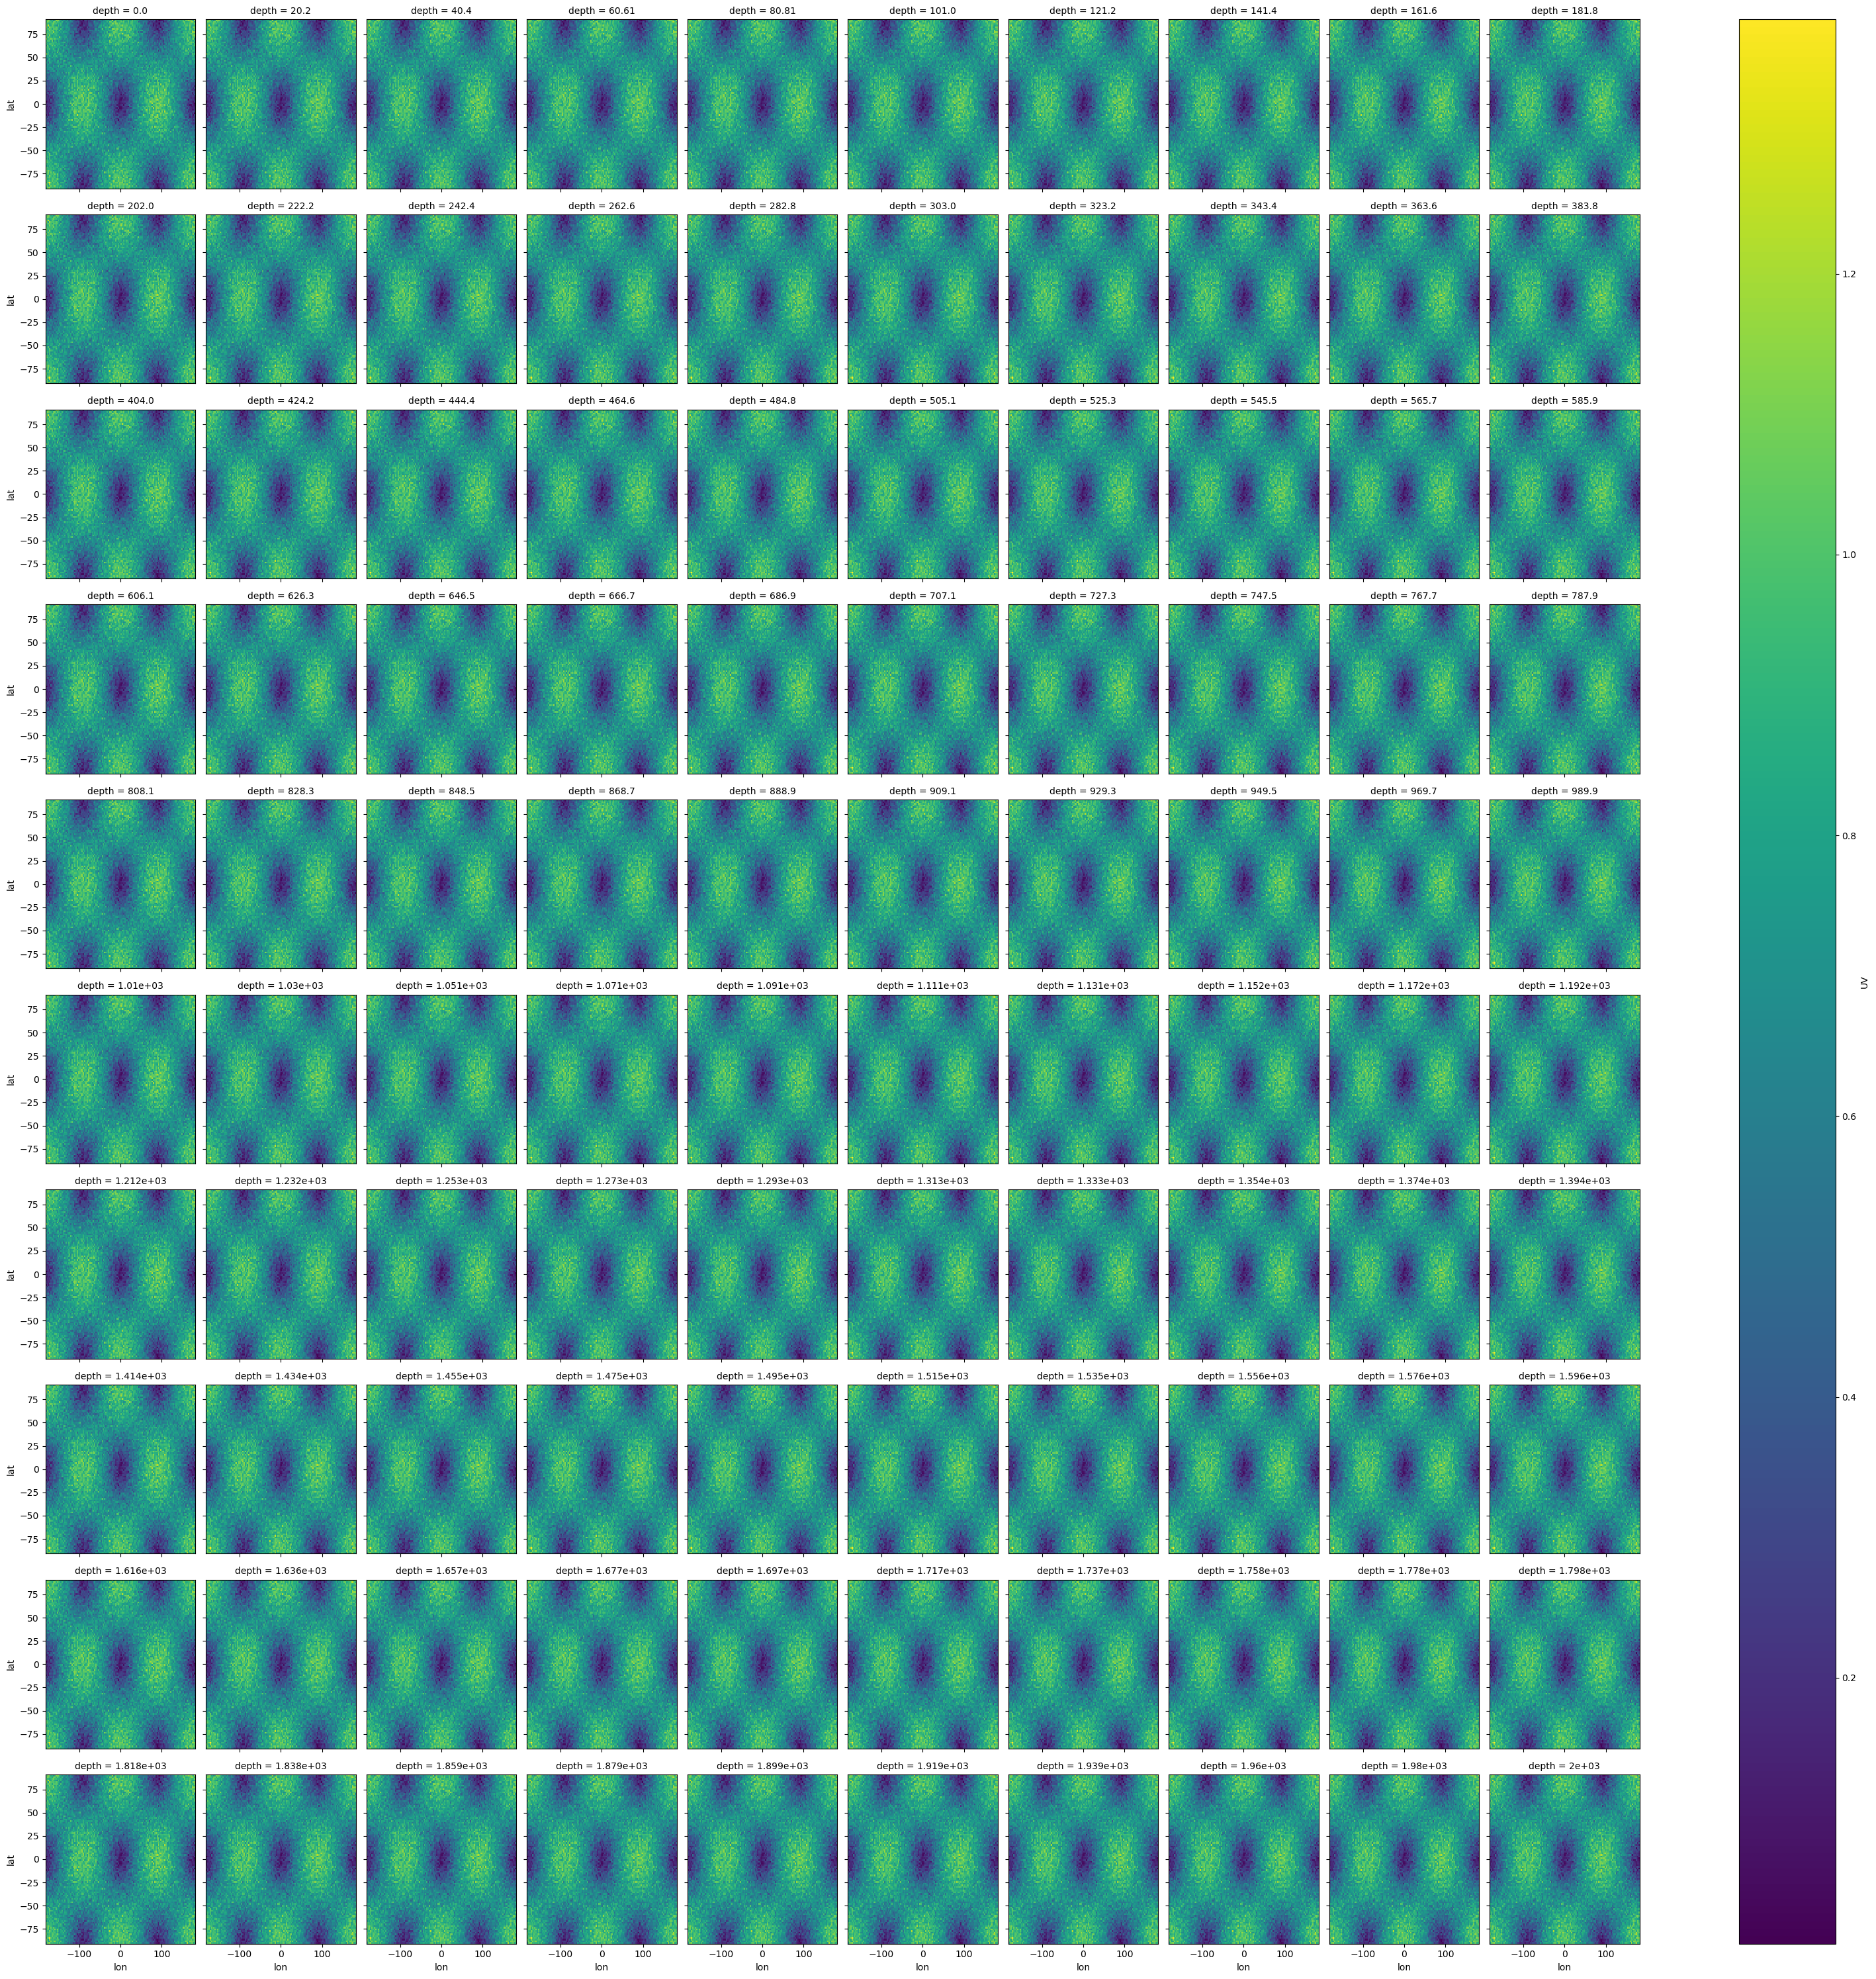

In [45]:
# ds.UV.plot(x="lon", y="lat", col="time", col_wrap=5)
# ds.V.plot(x="lon", y="lat", col="time", col_wrap=5)
ds.UV.isel(time=slice(1)).plot(x="lon", y="lat", col="depth", col_wrap=10)

In [47]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 47, depth: 100, lat: 100, lon: 120)
Coordinates:
  * time     (time) datetime64[ns] 376B 2025-01-01 2025-01-02 ... 2025-02-16
  * depth    (depth) float64 800B 0.0 20.2 40.4 ... 1.96e+03 1.98e+03 2e+03
  * lat      (lat) float64 800B -90.0 -88.18 -86.36 -84.55 ... 86.36 88.18 90.0
  * lon      (lon) float64 960B -180.0 -177.0 -173.9 ... 173.9 177.0 180.0
Data variables:
    U        (time, depth, lat, lon) float64 451MB -0.04709 ... -0.01264
    V        (time, depth, lat, lon) float64 451MB -0.7477 -1.03 ... 1.179
    UV       (time, depth, lat, lon) float64 451MB 0.7492 1.034 ... 0.8194 1.179

In [48]:

variables = {
    "U": "U",
    "V": "V",
}
dimensions = {"lat": "lat", "lon": "lon", "time": "time", "depth":"depth"}
fieldset = parcels.FieldSet.from_xarray_dataset(ds, variables, dimensions)

# data["U"][:, :, 0] = 0.0

In [49]:
# uppermost layer in the hydrodynamic data
fieldset.mindepth = fieldset.U.depth[0]

# Define a new Particle type including extra Variables
ArgoParticle = parcels.JITParticle.add_variables(
    [
        # Phase of cycle:
        # init_descend=0,
        # drift=1,
        # profile_descend=2,
        # profile_ascend=3,
        # transmit=4
        parcels.Variable("cycle_phase", dtype=np.int32, initial=0.0),
        parcels.Variable("cycle_age", dtype=np.float32, initial=0.0),
        parcels.Variable("drift_age", dtype=np.float32, initial=0.0),
        # if fieldset has temperature
        # Variable('temp', dtype=np.float32, initial=np.nan),
    ]
)

# Initiate one Argo float in the Agulhas Current
pset = parcels.ParticleSet(
    fieldset=fieldset, pclass=ArgoParticle, lon=[32], lat=[-31], depth=[0]
)

# combine Argo vertical movement kernel with built-in Advection kernel
kernels = [ArgoVerticalMovement, parcels.AdvectionRK4]

# Create a ParticleFile object to store the output
output_file = pset.ParticleFile(
    name="argo_float2",
    outputdt=timedelta(minutes=15),
    chunks=(1, 500),  # setting to write in chunks of 500 observations
)

# Now execute the kernels for 30 days, saving data every 30 minutes
pset.execute(
    kernels,
    runtime=timedelta(days=30),
    dt=timedelta(minutes=15),
    output_file=output_file,
)

INFO: Output files are stored in argo_float2.zarr.
100%|█████████████████████████████████████████████████████| 2592000.0/2592000.0 [04:59<00:00, 8658.07it/s]


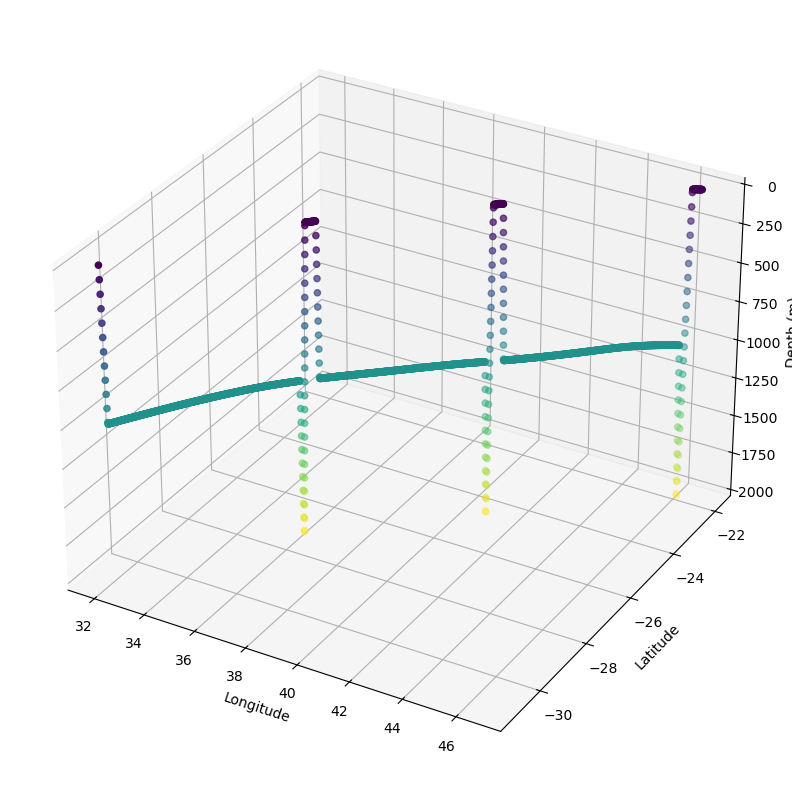

In [50]:
import matplotlib.pyplot as plt
import xarray as xr
from mpl_toolkits.mplot3d import Axes3D

ds_traj = xr.open_zarr("argo_float2.zarr")
x = ds_traj["lon"][:].squeeze()
y = ds_traj["lat"][:].squeeze()
z = ds_traj["z"][:].squeeze()
ds_traj.close()

fig = plt.figure(figsize=(13, 10))
ax = plt.axes(projection="3d")
cb = ax.scatter(x, y, z, c=z, s=20, marker="o")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (m)")
ax.set_zlim(np.max(z), 0)
plt.show()

####  Stommel gyre trial

In [23]:
import math
import numpy as np
import parcels

def generate_uv_fieldset(xdim=200, ydim=200, grid_type="A"):
    # Define the physical domain size (meters)
    a = b = 10000 * 1e3  
    scalefac = 0.05  # scaling factor for velocities
    dx, dy = a / xdim, b / ydim

    # Create spatial coordinates (lon, lat)
    lon = np.linspace(0, a, xdim, dtype=np.float32)
    lat = np.linspace(0, b, ydim, dtype=np.float32)

    # Create time and depth dimensions (here single time and depth level)
    time = np.array([0], dtype=np.float64)     # one time step at t=0
    depth = np.array([0], dtype=np.float32)      # one depth level at z=0

    # Initialize 2D fields for U (zonal) and V (meridional)
    U2d = np.zeros((lat.size, lon.size), dtype=np.float32)
    V2d = np.zeros((lat.size, lon.size), dtype=np.float32)

    # Parameters for the stommel-type current
    beta = 2e-11
    r = 1 / (11.6 * 86400)
    es = r / (beta * a)

    # Compute U and V on the 2D grid
    for j in range(lat.size):
        for i in range(lon.size):
            xi = lon[i] / a
            yi = lat[j] / b
            if grid_type == "A":
                U2d[j, i] = (
                    -(1 - math.exp(-xi / es) - xi)
                    * math.pi**2
                    * np.cos(math.pi * yi)
                    * scalefac
                )
                V2d[j, i] = (
                    (math.exp(-xi / es) / es - 1)
                    * math.pi
                    * np.sin(math.pi * yi)
                    * scalefac
                )

    # Expand the 2D fields to 4D by adding time and depth dimensions.
    # The new shape will be (time, depth, lat, lon)
    U4d = U2d[np.newaxis, np.newaxis, :, :]
    V4d = V2d[np.newaxis, np.newaxis, :, :]

    # Create the fieldset using the extended dimensions.
    data = {"U": U4d, "V": V4d}
    dimensions = {"lon": lon, "lat": lat, "time": time, "depth": depth}
    fieldset = parcels.FieldSet.from_data(data, dimensions, mesh="flat")
    
    return fieldset

# Example usage
if __name__ == "__main__":
    fs = generate_uv_fieldset()
    print("FieldSet created with dimensions:")
    print("Longitude:", fs.dimensions["lon"])
    print("Latitude:", fs.dimensions["lat"])
    print("Time:", fs.dimensions["time"])
    print("Depth:", fs.dimensions["depth"])


FieldSet created with dimensions:


AttributeError: 'FieldSet' object has no attribute 'dimensions'

In [27]:
fs = generate_uv_fieldset()

import matplotlib.pyplot as plt
# Extract the 1-time and 1-depth slice from the 4D fields (time, depth, lat, lon)
U = fs.U.data[0, 0, :]
V = fs.V.data[0, 0, :]

# Get the longitude and latitude arrays
lon = fs.dimensions["lon"]
lat = fs.dimensions["lat"]

# Create a meshgrid for plotting
Lon, Lat = np.meshgrid(lon, lat)

# Create the quiver plot
plt.figure(figsize=(10, 8))
plt.quiver(Lon, Lat, U, V, scale=5e-2, pivot='mid', color='blue')
plt.xlabel("Longitude (m)")
plt.ylabel("Latitude (m)")
plt.title("Stommel Gyre U-V Field")
plt.grid(True)
plt.show()

AttributeError: 'FieldSet' object has no attribute 'dimensions'